In [1]:
#htsf\Scripts\activate    

# Import libraries
import pandas as pd
from plotnine import ggplot, aes, geom_line
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from dateutil.relativedelta import relativedelta
import itertools

%matplotlib inline



def get_data(file_loc, verbose=True):
    data = pd.read_csv(file_loc)
    # Update Data Types
    data['date'] = pd.to_datetime(data['date'])
    data['subcategory'] = data['subcategory'].astype('category')
    data['category'] = data['category'].astype('category')
    if verbose is True:
        display(data.head())
        data.info()
    return data

# Read data
h_df = get_data('../data/hierarchal_agg.csv')
g_df = get_data('../data/grouped_agg.csv')

,date,category,subcategory,value
0,2021-01-01,category 1,subcat 1,1.0
1,2021-02-01,category 1,subcat 1,2.0
2,2021-03-01,category 1,subcat 1,3.0
3,2021-04-01,category 1,subcat 1,3.3
4,2021-05-01,category 1,subcat 1,5.4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         120 non-null    datetime64[ns]
 1   category     120 non-null    category      
 2   subcategory  120 non-null    category      
 3   value        120 non-null    float64       
dtypes: category(2), datetime64[ns](1), float64(1)
memory usage: 2.6 KB


,date,category,subcategory,value
0,2021-01-01,category 1,subcat 1,1.0
1,2021-02-01,category 1,subcat 1,2.0
2,2021-03-01,category 1,subcat 1,3.0
3,2021-04-01,category 1,subcat 1,3.3
4,2021-05-01,category 1,subcat 1,5.4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         288 non-null    datetime64[ns]
 1   category     288 non-null    category      
 2   subcategory  288 non-null    category      
 3   value        288 non-null    float64       
dtypes: category(2), datetime64[ns](1), float64(1)
memory usage: 5.5 KB


In [3]:
# Exploratory Analysis

def get_column_description(data):
    for col in data.columns:
        if data[col].dtype == 'category':
            print(f'{col} unique values: {len(data[col].unique())}\n')
        elif data[col].dtype == 'datetime64[ns]':
            print(f'Min Date: {data[col].min()}')
            print(f'Max Date: {data[col].max()}\n')
        else:
            print(f'{col}:\n{data[col].describe()}\n')

get_column_description(h_df)

Min Date: 2021-01-01 00:00:00
Max Date: 2022-12-01 00:00:00

category unique values: 2

subcategory unique values: 5

value:
count    120.000000
mean       6.240000
std        5.328556
min        0.000000
25%        2.000000
50%        5.000000
75%        9.000000
max       25.000000
Name: value, dtype: float64



In [4]:
get_column_description(g_df)

Min Date: 2021-01-01 00:00:00
Max Date: 2022-12-01 00:00:00

category unique values: 3

subcategory unique values: 5

value:
count    288.000000
mean       9.032639
std        9.622917
min        0.000000
25%        3.000000
50%        6.000000
75%       11.850000
max       50.700000
Name: value, dtype: float64



,date,category,subcategory,value
date,,,,
2021-01-01,2021-01-01,category 1,subcat 2,2.0
2021-02-01,2021-02-01,category 1,subcat 2,1.0
2021-03-01,2021-03-01,category 1,subcat 2,2.0
2021-04-01,2021-04-01,category 1,subcat 2,5.0
2021-05-01,2021-05-01,category 1,subcat 2,12.0
2021-06-01,2021-06-01,category 1,subcat 2,24.0
2021-07-01,2021-07-01,category 1,subcat 2,20.0
2021-08-01,2021-08-01,category 1,subcat 2,19.0
2021-09-01,2021-09-01,category 1,subcat 2,10.0


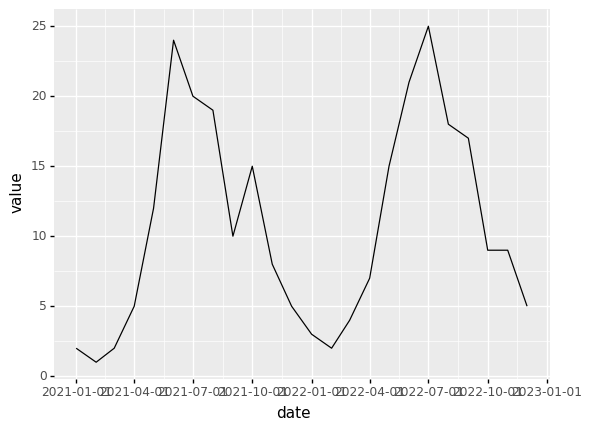

<ggplot: (188450142489)>

In [5]:
# Example of category with all dates with one subcategory
example = h_df.loc[(h_df.category == 'category 1') & (h_df.subcategory == 'subcat 2')].sort_values(by='date')
example.index = pd.DatetimeIndex(example.date, freq=pd.DatetimeIndex(example.date).inferred_freq)

display(example)

(
    ggplot(example)
    + aes(x='date', y='value')
    + geom_line()
)

In [7]:
# Heirarchal - Each subcategory is a part of the whole for each category; Each Team member is part of the overall Team

def get_hierarchy_labels(data, grp1, grp2, sep='_'):
    new_ = f'{grp1}_{grp2}'
    data[new_] = data.apply(lambda x: f'{x[grp1]}{sep}{x[grp2]}', axis=1)
    g1s = data[grp1].unique().tolist()
    g2s = data[grp2].unique().tolist()
    ngs = data[new_].unique().tolist()
    btm = {k: [v for v in ngs if k == v.split(sep)[0]] for k in g1s}
    btm = list(itertools.chain.from_iterable(btm.values()))
    labs = ['total'] + g2s + g1s + btm
    return new_, btm, labs

def get_hierarchal(data, grp1, grp2, date_col='date', val='value'):
    new_, btm, labs = get_hierarchy_labels(data, grp1, grp2)
    hd = data.pivot(index=date_col, columns=new_, values=val)\
        .join(
            data.groupby([date_col, grp2], as_index=False, observed=True)\
                .agg({val : lambda x: data.loc[x.index][val].sum()})\
                    .pivot(index=date_col, columns=grp2, values=val)
            )\
            .join(
                data.groupby([date_col, grp1], as_index=False, observed=True)\
                    .agg({val : lambda x: data.loc[x.index][val].sum()})\
                        .pivot(index=date_col, columns=grp1, values=val)
                )\
                    .join(
                        data.groupby(date_col, observed=True)\
                            .agg({val : lambda x: data.loc[x.index][val].sum()})\
                                .rename(columns={val:'total'})
                        )[labs]
    hd.index = pd.DatetimeIndex(hd.index, freq=hd.index.inferred_freq)
    return hd, btm, labs

def map_hierarchies(col, sep='_'):
    col.loc[col.name.split(sep)] = 1
    return col

def get_S(btm, labs):
    return np.vstack((
        np.ones(len(btm)), 
        pd.DataFrame(index=labs[1:len(labs)-len(btm)], columns=btm, data=0).apply(lambda x: map_hierarchies(x)).values, 
        np.identity(len(btm))))

def hier_arima(col, forecast_idx, order=(1,1,0), steps_out=1):
    mod = ARIMA(col.diff(), order=order, enforce_stationarity=False)
    mod = mod.fit(method_kwargs={'warn_convergence': False})
    if steps_out == 1:
        yhat = mod.predict(forecast_idx).values + col.iloc[-1]
    else:
        yhat = mod.predict(start=forecast_idx[0], end=forecast_idx[-1]).values 
        yhat[0] += col.iloc[-1]
        yhat = np.cumsum(yhat)
    out = {col.name:{'yhat':yhat, 'training_df':col, 'model':mod}}
    return out

def get_models(hdf, order=(1,1,0), steps_out=1, period='months'):
    if period.lower() in ['month', 'months']:
        if steps_out == 1:
            forecast_idx = hdf.index[-1] + relativedelta(months=1)
        else:
            forecast_idx = pd.date_range(
                hdf.index[-1] + relativedelta(months=1), 
                hdf.index[-1] + relativedelta(months=steps_out), 
                freq=hdf.index.freq)
        cols_dict = dict()
        mods = {'steps_out':steps_out, 'period':period, 'index':forecast_idx}
        hdf.apply(lambda x: cols_dict.update(hier_arima(col=x, forecast_idx=forecast_idx, order=order, steps_out=steps_out)))
        mods.update({'columns':cols_dict})
        return mods
    else:
        raise ValueError('Invalid period')

def get_forecast_matrix(mods):
    labs = list(mods['columns'].keys())
    for i in range(0, len(labs)):
        if i == 0:
            out = mods['columns'][labs[i]]['yhat'][:, np.newaxis]
        else:
            out = np.concatenate((out, mods['columns'][labs[i]]['yhat'][:, np.newaxis]), axis=1)
    return out

def reconcile(yh, s_matrix, method='ols'):
    if method.lower() == 'ols':
        ols = np.dot(np.dot(s_matrix, np.linalg.inv(np.dot(np.transpose(s_matrix), s_matrix))), np.transpose(s_matrix))
        rec = np.array([np.dot(ols, np.transpose(yh[x, :])) for x in range(yh.shape[0])])
        return rec
    else:
        raise ValueError('Invalid method')

# Grouped hierarchy
hierarchy_df, h_bottom, h_labels = get_hierarchal(h_df, 'category', 'subcategory')   
h_s = get_S(h_bottom, h_labels)
h_models = get_models(hierarchy_df, steps_out=4)
h_yhat = get_forecast_matrix(h_models)
h_reconciled_yhat = reconcile(h_yhat, h_s, method='ols')

# Grouped hierarchy
grouped_df, g_bottom, g_labels = get_hierarchal(g_df, 'category', 'subcategory')   
g_s = get_S(g_bottom, g_labels)
g_models = get_models(grouped_df, steps_out=4)
g_yhat = get_forecast_matrix(g_models)
g_reconciled_yhat = reconcile(g_yhat, g_s, method='ols')